In [1]:
from utility import *
from models import * 
from dataloader import *
my_module_path = os.path.join("../", '21cm-wrapper')
sys.path.append(my_module_path)
from Leaf import *

device = 'cuda'

#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism

NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# hyperparams
data_path = "/home/potato/Documents/projects/master/data/datax5/"
batch_size = 32
epochs = 120
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-4,
}

loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model_sn = SumnetHandler(Model = Summary_net_lc_super_smol,
                     Training_data=train_dataloader, Test_data=test_dataloader, device=device)
'''
# train
model_sn.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model_sn.test(Validation_data = test_dataloader, Model = model_sn.Model, 
                lossf=loss(**loss_params))'''
                
model_sn.load("./summary_net.pt")

model_de = flow_net(in_dim=6, cond_dim=6, n_blocks=6, n_nodes=60)

/home/potato/Documents/projects/master/21cm-sbi/dataloader.py:196: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Model.load_state_dict(torch.load(name, map_location=tor

|████████████████████████████████████████| 20/20 [100%] in 10:05.1 (0.03/s)     


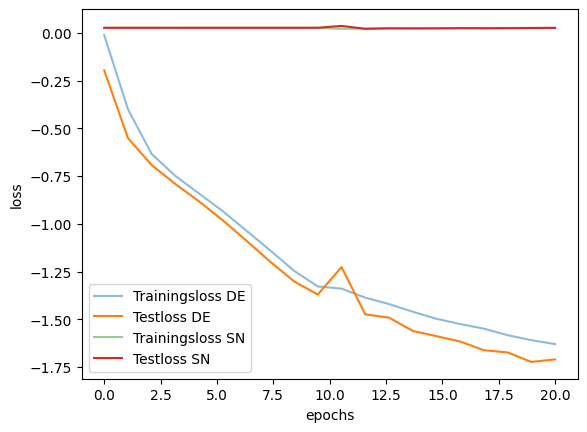

<Figure size 640x480 with 0 Axes>

In [3]:
prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, prior=prior, device=device)

sbi.train(training_data = train_dataloader, test_data = test_dataloader,
          epochs = 20, summary_net_freezed_epochs = 10, 
          summary_net_pretrain_epochs = 0, optimizer = optimizer,
              optimizer_kwargs= optimizer_params, loss_function = torch.nn.MSELoss, 
              loss_params = {}, device=device, plot= True)

/home/potato/Documents/projects/master/21cm-sbi/dataloader.py:526: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.density_estimator.load_state_dict(torch.load(path + "de

torch.Size([10000, 6])


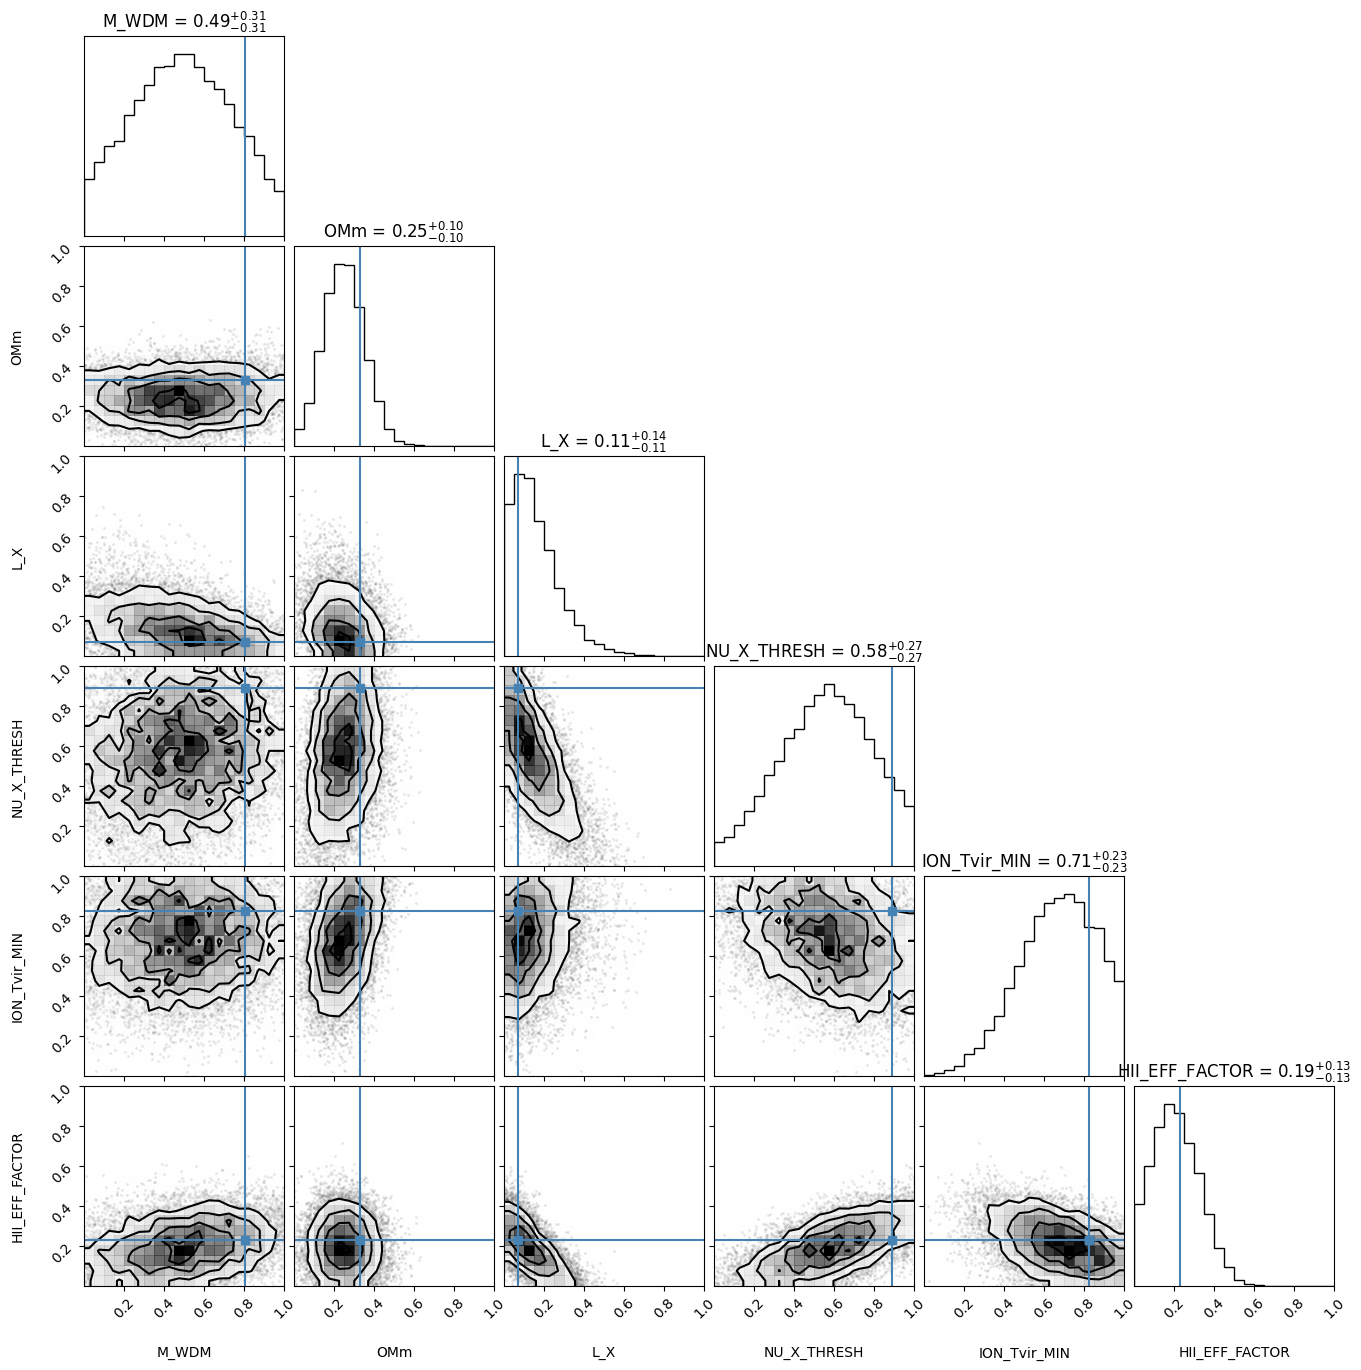

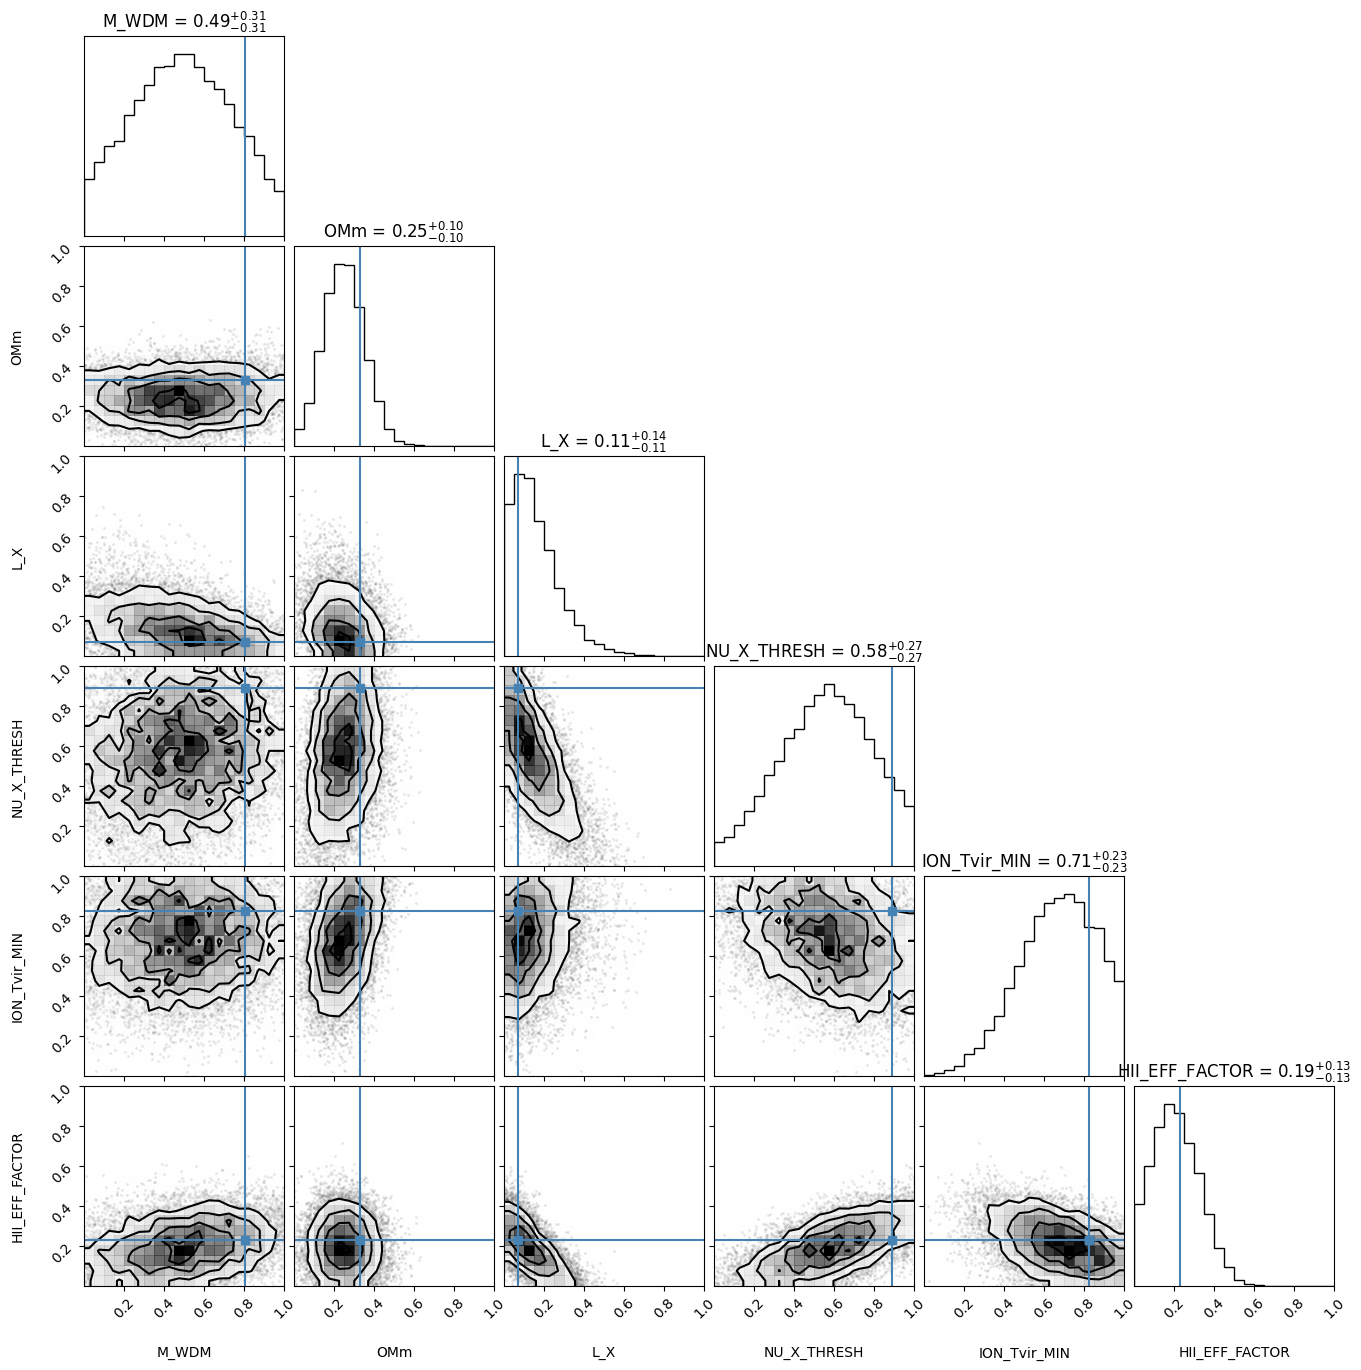

In [9]:
prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, prior=prior, device=device)
sbi.load_model()

lab, img, _ = test_dataloader.dataset[0]

lab, img = lab.to(device), img.to(device)
img = img.unsqueeze(0)

summary = sbi.summary_net(img)

samples, log_prob = sbi.density_estimator.sample(num_sampels=10000, c=summary)
print(samples.shape)
from corner import corner
corner(samples.detach().to('cpu').numpy(), truths=lab.to('cpu').numpy(),
       labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
       range=[(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)], show_titles=True)

In [7]:
sbi.save_model()

In [ ]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, FMPE
from sbi import utils, analysis
from sbi.utils import RestrictedPrior, get_density_thresholder

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none', 
)

# train the maf
inference = FMPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=5,
                                    stop_after_epochs=20,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    #fig.savefig(f"./NPE_{i}.png", dpi=300)

ImportError: cannot import name 'NPE_A' from partially initialized module 'sbi.inference.trainers.npe' (most likely due to a circular import) (/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/trainers/npe/__init__.py)

In [ ]:
### SNPE - backup ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none', 
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=5,
                                    stop_after_epochs=20,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    #fig.savefig(f"./NPE_{i}.png", dpi=300)

/tmp/ipykernel_103428/4198018834.py:16: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator_build_fun = posterior_nn(


|                                        | ▁▃▅ 0/20 [0%] in 0s (~0s, 0.0/s) 

on 0: test_loss_density_net[-1]=3.4271658148084367 test_loss_summary_net[-1]=0.01652666609734297
on 1: test_loss_density_net[-1]=-0.6513249295098441 test_loss_summary_net[-1]=0.016438771837524006
on 2: test_loss_density_net[-1]=-4.68853063583374 test_loss_summary_net[-1]=0.016433865018188953
on 3: test_loss_density_net[-1]=-6.4755795887538365 test_loss_summary_net[-1]=0.016612660326063632
on 4: test_loss_density_net[-1]=-6.985252121516637 test_loss_summary_net[-1]=0.01645660006574222
on 5: test_loss_density_net[-1]=-6.905849661145892 test_loss_summary_net[-1]=0.017286823530282294
on 6: test_loss_density_net[-1]=-6.0345950671604704 test_loss_summary_net[-1]=0.019210536245788848
on 7: test_loss_density_net[-1]=-7.407653181893485 test_loss_summary_net[-1]=0.016954990130450043
on 8: test_loss_density_net[-1]=-2.6171765736171175 test_loss_summary_net[-1]=0.02559716712151255
on 9: test_loss_density_net[-1]=-7.250263609204974 test_loss_summary_net[-1]=0.017849868323121753
on 10: test_loss_den

KeyboardInterrupt: 

In [ ]:
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )

torch.Size([1, 6]) torch.Size([1, 1, 28, 28, 470])


KeyboardInterrupt: 

In [ ]:
for i in range(10):
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)

    x = x.to(device)

    x = model.Model(x).detach()
    sample, prob = density_net.sample_and_log_prob(sample_shape=torch.tensor([1]), condition=x.to('cuda'))
    print("summary-vec = ", x)
    print("true-vec = ", y)
    print("sample-vec = ", sample.detach())
    print("prob = ", prob.item())
    print()
    

summary-vec =  tensor([[0.5040, 0.1809, 0.0455, 0.6826, 0.7677, 0.2343]], device='cuda:0')
true-vec =  tensor([[0.8062, 0.3305, 0.0681, 0.8902, 0.8267, 0.2283]])
sample-vec =  tensor([[[ 0.0698, -7.3732, 21.8594, -4.6525, -3.6671, -3.3920]]],
       device='cuda:0')
prob =  -21.83407211303711

summary-vec =  tensor([[0.5257, 0.1048, 0.4010, 0.1109, 0.6921, 0.5230]], device='cuda:0')
true-vec =  tensor([[0.4290, 0.2942, 0.3074, 0.1546, 0.7543, 0.4685]])
sample-vec =  tensor([[[ 12.0757, -16.4293,   9.1887,  -1.5900,  -1.2169,   4.2351]]],
       device='cuda:0')
prob =  -21.584089279174805

summary-vec =  tensor([[0.5034, 0.3658, 0.0262, 0.6285, 0.0685, 0.1522]], device='cuda:0')
true-vec =  tensor([[0.7000, 0.3914, 0.0371, 0.7115, 0.0493, 0.1985]])
sample-vec =  tensor([[[ -6.6424,   2.2357,   5.8239,   1.3249,  15.7911, -13.6029]]],
       device='cuda:0')
prob =  -22.218017578125

summary-vec =  tensor([[0.4769, 0.8191, 0.8496, 0.6382, 0.1667, 0.8316]], device='cuda:0')
true-vec =  t

In [ ]:
?

Signature:
density_net.sample_and_log_prob(
    sample_shape: torch.Size,
    condition: torch.Tensor,
    **kwargs,
) -> Tuple[torch.Tensor, torch.Tensor]
Docstring:
Return samples and their density from the density estimator.

Args:
    sample_shape: Shape of the samples to return.
    condition: Conditions of shape (sample_dim, batch_dim, *event_shape).

Returns:
    Samples of shape `(*sample_shape, condition_batch_dim, *input_event_shape)`
    and associated log probs of shape `(*sample_shape, condition_batch_dim)`.
File:      ~/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/neural_nets/density_estimators/nflows_flow.py
Type:      method

In [ ]:
torch.unsqueeze(train_dataloader.dataset.__getitem__(0)[1],0).shape

In [ ]:
with open("delete.me", "wb") as handle:
    pickle.dump(density_net, handle)

In [ ]:
train_loss_summary_net, train_loss_density_net, test_loss_summary_net, test_loss_density_net = statistics
plt.plot(train_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{train}}$')
plt.plot(np.asarray(train_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{train}}$')   
plt.plot(test_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{test}}$')
plt.plot(np.asarray(test_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{test}}$')
plt.vlines(9, 0.5, 0, color='b', label='joint learning', colors='black')
plt.legend()
#plt.savefig("NPE_nsf_joint_loss.png", dpi=400)
plt.show()


In [ ]:
### NRE ###


from sbi.utils.get_nn_models import (
    classifier_nn
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNRE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net2.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
ratio_estimator = classifier_nn(
    model = 'resnet', z_score_x='none',  z_score_theta='none'
)

# train the maf
inference = SNRE(prior=prior, device=device, classifier=ratio_estimator)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]

density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=10,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

In [ ]:
from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot

In [ ]:
from sbi.utils.torchutils import repeat_rows
from torch import eye, ones
num_atoms=10

y,x,_ = test_dataloader.dataset.__getitem__(0)
y,x = y.unsqueeze(0), x.unsqueeze(0)
print(y.shape, x.shape)
x = model.Model(x)

y1, x1,_ = test_dataloader.dataset.__getitem__(1)
y1,x1 = y1.unsqueeze(0), x1.unsqueeze(0)
x1 = model.Model(x1)

y, x = torch.cat((y,y1)), torch.cat((x,x1))

batch_size = y.shape[0]
print(f'{batch_size=}')

repeated_x = repeat_rows(x, num_atoms)
print(f'{repeated_x=}')

# Choose `1` or `num_atoms - 1` thetas from the rest of the batch for each x.
probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
print(f'{probs=}')

choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)

In [ ]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

In [ ]:
test = 0 if 0 == 1 elif

In [ ]:
from sbi import utils, analysis

from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot
import corner
import numpy as np
import arviz
import pickle
from sbi.inference.posteriors import MCMCPosterior

In [ ]:
with open("../NRE_de.pkl", "rb") as handle:
    posterior = pickle.load(handle)

posterior.potential_fn.device = 'cpu'
posterior = MCMCPosterior(potential_fn=posterior.potential_fn,
                          proposal=posterior.proposal,
                          theta_transform=posterior.theta_transform,
                          method='slice_np_vectorized',
                          thin=posterior.thin,
                          warmup_steps=posterior.warmup_steps,
                          num_chains=6,
                          num_workers=6,
                          device='cpu')

model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("../NRE_sn.pt")
sum_net = model.Model

with torch.no_grad():
    with alive_bar(len(test_dataloader), force_tty=True, refresh_secs=1) as bar:
        for i, (lab, img,_) in enumerate(test_dataloader):
            img, lab = img.to(device), lab.to(device)
            
            if not i:
                summary_vec = torch.empty(0,lab.shape[1], device=device)
                labels = torch.empty(0,lab.shape[1], device=device)

            pred = sum_net(img)
            summary_vec = torch.cat((summary_vec, pred), dim=0)
            labels = torch.cat((labels, lab), dim=0)
            bar()

xs = summary_vec
thetas = labels
num_sbc_runs = xs.shape[0]
num_posterior_samples = num_sbc_runs

#xs, thetas = model.full_inference(sbc_dataloader)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

fig, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
    parameter_labels = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],
)

fig.savefig("NRE_sbc_rank_maf_freezed_sum.png", dpi=300)

fig, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=[r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],)
fig.savefig("NRE_sbc_CDF_maf_freezed_sum.png", dpi=300)

In [ ]:
posterior.potential_fn

In [ ]:
for x,y,_ in train_dataloader:
    print(x.shape, y.shape)
    breal

In [ ]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)


# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))